# Proyecto final NLP: Clasificación de proteínas que degradan plástico.



In [24]:
#cargar el drive para el uso de los archivos de datos y utils
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
#importar el archivo utils
!cp "/content/drive/MyDrive/Colab_Notebooks/Taller2_NPL/utils2.py" .

In [26]:
# Import Python libraries and helper functions (in utils2) 
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from utils2 import sigmoid, get_batches, compute_pca, get_dict
from matplotlib import pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [28]:
secuencias = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Taller2_NPL/secuencias.csv')
secuencias = secuencias['sequence']

In [29]:
secuencias

0       MKHPYGYRWHWLYALVVTLMTALATFSAHAAVTAGPGAWSSQQTWA...
1       MPLRTLLCGLLLAVCLGQHALAASRCSERPRTLLRPAEVSCSYQST...
2       MRNTLKAAFKLGVISAALLAPFATQAATAGPGAWSSQQTWAADSVN...
3       MLAKQIKKANSRSTLLRKSLLFAAPIILAVSSSSVYALTQVSNFGT...
4       MMSSQTTQSSKFSLFLKRGLLLAAAPLLAMSASSALAATQVTGFGS...
                              ...                        
999     MKTTTPLVHVASVEKGRSYEDFQKVYNAIALKLREDDEYDNYIGYG...
1000    LVHVASVEKGRSYEDFQKVYNAIALKLREDDEYDNYIGYGPVLVRL...
1001    LVHVASVEKGRSYEDFQKVYNAIALKLREDDEYDNYIGYGPVLVRL...
1002    MKTLVHVASVEKGRSYEDFQKVYNAIALKLREDDEYDNYIGYGPVL...
1003    MKTLVHVASVEKGRSYEDFQKVYNAIALKLREDDEYDNYIGYGPVL...
Name: sequence, Length: 1004, dtype: object

In [30]:
#Cada letra en la secuencia va a representar un token
data = []
for secuencia in range(0,len(secuencias)):
  for lon in range(0,len(secuencias[secuencia])):
    data.append(secuencias[secuencia][lon])

print("Number of tokens:", len(data),'\n', data[:15])


Number of tokens: 319499 
 ['M', 'K', 'H', 'P', 'Y', 'G', 'Y', 'R', 'W', 'H', 'W', 'L', 'Y', 'A', 'L']


In [31]:
data[:20]

['M',
 'K',
 'H',
 'P',
 'Y',
 'G',
 'Y',
 'R',
 'W',
 'H',
 'W',
 'L',
 'Y',
 'A',
 'L',
 'V',
 'V',
 'T',
 'L',
 'M']

In [32]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  22
Most frequent tokens:  [('A', 30840), ('G', 30333), ('L', 26566), ('V', 20341), ('S', 19118), ('E', 18015), ('K', 17574), ('T', 17530), ('D', 17502), ('I', 15717), ('R', 15650), ('P', 14579), ('N', 13119), ('F', 11537), ('Q', 11155), ('Y', 9961), ('C', 8397), ('H', 7385), ('M', 6593), ('W', 4080)]


In [33]:
fdist

FreqDist({'A': 30840, 'G': 30333, 'L': 26566, 'V': 20341, 'S': 19118, 'E': 18015, 'K': 17574, 'T': 17530, 'D': 17502, 'I': 15717, ...})

#### Mapping words to indices and indices to words
We provide a helper function to create a dictionary that maps words to indices and indices to words.

In [34]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  22


In [35]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  22


In [36]:
word2Ind

{'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'F': 4,
 'G': 5,
 'H': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'P': 12,
 'Q': 13,
 'R': 14,
 'S': 15,
 'T': 16,
 'U': 17,
 'V': 18,
 'W': 19,
 'X': 20,
 'Y': 21}

In [37]:
Ind2word

{0: 'A',
 1: 'C',
 2: 'D',
 3: 'E',
 4: 'F',
 5: 'G',
 6: 'H',
 7: 'I',
 8: 'K',
 9: 'L',
 10: 'M',
 11: 'N',
 12: 'P',
 13: 'Q',
 14: 'R',
 15: 'S',
 16: 'T',
 17: 'U',
 18: 'V',
 19: 'W',
 20: 'X',
 21: 'Y'}

*ENTRENAR MODELO DE EMBEDINGS*

In [38]:
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    np.random.seed(random_seed)
    # W1 has shape (N,V)
    W1 = np.random.uniform(0,1,(N,V))
    
    # W2 has shape (V,N)
    W2 = np.random.uniform(0,1,(V,N))
    
    # b1 has shape (N,1)
    b1 = np.random.uniform(0,1,(N,1))
    
    # b2 has shape (V,1)
    b2 = np.random.uniform(0,1,(V,1))
    
    ### END CODE HERE ###
    return W1, W2, b1, b2

In [40]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    # Calculate yhat (softmax)    
    yhat = np.exp(z)/np.sum(np.exp(z),axis=0)
    ### END CODE HERE ###
    return yhat

In [42]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    # Calculate h
    h = np.dot(W1,x)+b1
  
    # Apply the relu on h, 
    # store the relu in h
    h = np.maximum(0,h)

    # Calculate z
    z = np.dot(W2,h)+b2

    ### END CODE HERE ###

    return z, h

In [44]:
# compute_cost: cross-entropy cost function
def compute_cost(y, yhat, batch_size):

    # cost function 
    logprobs = np.multiply(np.log(yhat),y)  + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [46]:
tmp_x

array([[0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]])

In [47]:
tmp_y

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [48]:
tmp_x.shape

(22, 4)

In [49]:
tmp_y.shape

(22, 4)

In [50]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    ### START CODE HERE (Replace instanes of 'None' with your code) ###
    # Compute l1 as W2^T (Yhat - Y)
    # and re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T,yhat-y)

    # Apply relu to l1
    l1 = np.maximum(0,l1)

    # compute the gradient for W1
    grad_W1 =np.dot(l1,x.T)/batch_size

    # Compute gradient of W2
    grad_W2 = np.dot(yhat-y,h.T)/batch_size
    
    # compute gradient for b1
    grad_b1 = np.sum(l1, axis=1, keepdims=True) / batch_size

    # compute gradient for b2
    grad_b2 = np.sum(yhat - y, axis=1, keepdims=True) / batch_size
    ### END CODE HERE ####
    
    return grad_W1, grad_W2, grad_b1, grad_b2


In [52]:
def gradient_descent(data, word2Ind, N, V, num_iters, C,alpha=0.03, 
                     random_seed=282, initialize_model=initialize_model, 
                     get_batches=get_batches, forward_prop=forward_prop, 
                     softmax=softmax, compute_cost=compute_cost, 
                     back_prop=back_prop):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
        random_seed: random seed to initialize the model's matrices and vectors
        initialize_model: your implementation of the function to initialize the model
        get_batches: function to get the data in batches
        forward_prop: your implementation of the function to perform forward propagation
        softmax: your implementation of the softmax function
        compute_cost: cost function (Cross entropy)
        back_prop: your implementation of the function to perform backward propagation
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases after num_iters iterations

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=random_seed) #W1=(N,V) and W2=(V,N)

    batch_size = 128
#    batch_size = 512
    iters = 0
    #C = 2
    C = C
    
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        ### START CODE HERE (Replace instances of 'None' with your own code) ###                
        # get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
                
        # get yhat
        yhat = softmax(z)
        
        # get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
            
        # get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # update weights and biases
        W1 = W1 - alpha * grad_W1
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2

        ### END CODE HERE ###
        iters +=1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

**USO DEL MODELO CBOW PARA CONSEGUIR EMBEDINGS**

In [53]:
# test your function
# UNIT TEST COMMENT: Each time this cell is run the cost for each iteration changes slightly (the change is less dramatic after some iterations)
C = 4
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 250
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters,C)

Call gradient_descent
iters: 10 cost: 7.913822
iters: 20 cost: 5.228170
iters: 30 cost: 2.491564
iters: 40 cost: 3.810765
iters: 50 cost: 4.552711
iters: 60 cost: 3.958087
iters: 70 cost: 3.375270
iters: 80 cost: 5.405472
iters: 90 cost: 3.647667
iters: 100 cost: 4.300811
iters: 110 cost: 2.675050
iters: 120 cost: 3.345144
iters: 130 cost: 4.471210
iters: 140 cost: 4.384159
iters: 150 cost: 3.213109
iters: 160 cost: 3.388808
iters: 170 cost: 3.494055
iters: 180 cost: 4.372938
iters: 190 cost: 3.931979
iters: 200 cost: 5.276837
iters: 210 cost: 3.713729
iters: 220 cost: 4.574048
iters: 230 cost: 3.785508
iters: 240 cost: 3.748007
iters: 250 cost: 3.817119


## Visualización de word embedings

 

In [54]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['A', 'C', 'D', 'E', 'F','G','H',
         'I','K','L','M','N','P','Q','R','S','T','U','V','W','X','Y']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
#print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

**VISUALIZAR LOS AMINOACIDOS**

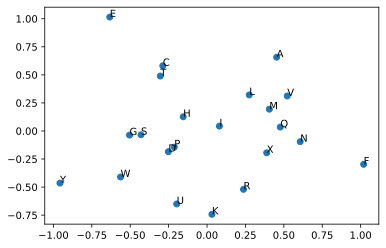

In [55]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

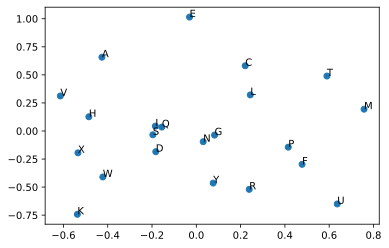

In [56]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()

**VISUALIZAR LAS PROTEINAS**

In [57]:
data_trans = []  

for secuencia in range(0,len(secuencias)):

  idx = []

  for lon in range(0,len(secuencias[secuencia])):
    amino = secuencias[secuencia][lon]
    idx.append(word2Ind[amino])

  #data_trans.append(embs[idx, :].sum(axis=0))
  data_trans.append(embs[idx, :].mean(axis=0))

In [58]:
data_trans = np.reshape(data_trans,(1004,50))

In [59]:
data_trans

array([[0.48714944, 0.57103666, 0.42963335, ..., 0.48775106, 0.41870548,
        0.45275124],
       [0.49848192, 0.50787207, 0.40778115, ..., 0.49988254, 0.42721535,
        0.48613905],
       [0.48930707, 0.57973457, 0.43508574, ..., 0.49044924, 0.41948576,
        0.45662149],
       ...,
       [0.46628888, 0.53399438, 0.45740359, ..., 0.49822707, 0.46716815,
        0.5103343 ],
       [0.46539921, 0.53638406, 0.46110925, ..., 0.49919276, 0.46744946,
        0.50916221],
       [0.46539921, 0.53638406, 0.46110925, ..., 0.49919276, 0.46744946,
        0.50916221]])

In [60]:
marca = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Taller2_NPL/ids.csv',sep=';')

In [61]:
marca

,id,Respuesta,Familia
0,1H,1,H
1,1H,1,H
2,1H,1,H
3,1H,1,H
4,1H,1,H
...,...,...,...
999,0Ox,0,Ox
1000,0Ox,0,Ox
1001,0Ox,0,Ox
1002,0Ox,0,Ox


In [62]:
grupo = np.array(marca.Familia)

In [63]:
grupo

array(['H', 'H', 'H', ..., 'Ox', 'Ox', 'Ox'], dtype=object)

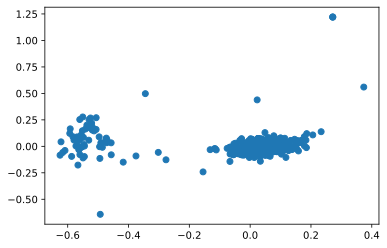

In [64]:
result= compute_pca(data_trans, 2)
pyplot.scatter(result[:, 0], result[:, 1])
#for i, word in enumerate(words):
#    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

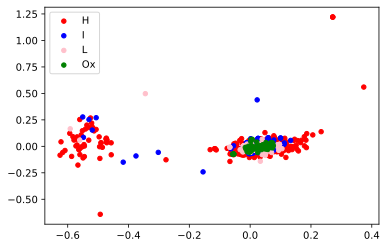

In [65]:
scatter_x = result[:, 0]
scatter_y = result[:, 1]
group = grupo
cdict = {'H':'red', 'I':'blue', 'L':'pink', 'Ox':'green'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 20)
ax.legend()
plt.show()

In [66]:
resp = np.array(marca.Respuesta)

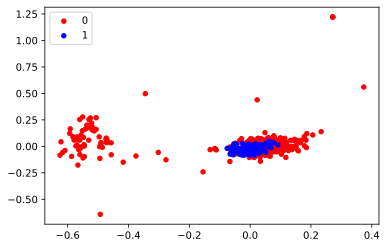

In [67]:
scatter_x = result[:, 0]
scatter_y = result[:, 1]
group = resp
cdict = {0:'red', 1:'blue'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 20)
ax.legend()
plt.show()

# IMPLEMENTACIÓN DE MODELO DE CLASIFICACIÓN DE PROTEÍNAS A PARTIR DE EMBEDINGS PRE ENTRENADOS

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd

import tensorflow_hub as hub
import numpy as np

In [145]:
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

In [147]:
embed(['hola','adios','hasta'])

<tf.Tensor: shape=(3, 250), dtype=float32, numpy=
array([[-2.73333900e-02, -1.54957818e-02, -9.24940929e-02,
         4.43051308e-02,  4.75522242e-02,  1.24300137e-01,
         2.68439343e-03, -9.80850458e-02,  3.06426617e-03,
         8.82446542e-02, -1.92723274e-02,  1.70212556e-02,
        -1.11383200e-02,  1.70805492e-02,  5.88092171e-02,
        -2.07868554e-02,  7.43056685e-02,  5.04972152e-02,
        -3.43043059e-02, -4.97969985e-03,  1.15483686e-01,
        -1.03998348e-01, -2.31708284e-03, -3.60034369e-02,
        -6.51984438e-02,  4.59700115e-02,  7.99144804e-02,
        -5.17302565e-03, -1.55900815e-03, -4.86366414e-02,
        -9.84415598e-03,  4.25363816e-02, -7.56190484e-03,
         5.67166507e-02,  1.13969602e-01,  1.83759347e-01,
        -9.92460735e-03,  4.03639860e-03,  4.16251794e-02,
         8.27532262e-02,  3.78634296e-02, -1.20819338e-01,
         3.65787335e-02,  3.64213213e-02, -7.50078410e-02,
        -9.74228326e-03,  4.27797027e-02,  4.81312163e-02,
      

In [4]:
def get_max_length(df):
    """
    get max token counts from train data, 
    so we use this number as fixed length input to RNN cell
    """
    max_length = 0
    for row in df['review']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

def get_word2vec_enc(reviews):
    """
    get word2vec value for each word in sentence.
    concatenate word in numpy array, so we can use it as RNN input
    """
    encoded_reviews = []
    for review in reviews:
        tokens = review.split(" ")
        word2vec_embedding = embed(tokens)
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews
        
def get_padded_encoded_reviews(encoded_reviews):
    """
    for short sentences, we prepend zero padding so all input to RNN has same length
    """
    padded_reviews_encoding = []
    for enc_review in encoded_reviews:
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, 250))
        for i in range(zero_padding_cnt):
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

def sentiment_encode(sentiment):
    """
    return one hot encoding for Y value
    """
    if sentiment == 'positive':
        return [1,0]
    else:
        return [0,1]
    
def preprocess(df):
    """
    encode text value to numeric value
    """
    # encode words into word2vec
    reviews = df['review'].tolist()
    
    encoded_reviews = get_word2vec_enc(reviews)
    padded_encoded_reviews = get_padded_encoded_reviews(encoded_reviews)
    # encoded sentiment
    sentiments = df['sentiment'].tolist()
    encoded_sentiment = [sentiment_encode(sentiment) for sentiment in sentiments]
    X = np.array(padded_encoded_reviews)
    Y = np.array(encoded_sentiment)
    return X, Y

In [5]:
movie_reviews_train = [
         {'review': 'this is the best movie', 'sentiment': 'positive'},
         {'review': 'i recommend you watch this movie', 'sentiment': 'positive'},
         {'review': 'it was waste of money and time', 'sentiment': 'negative'},
         {'review': 'the worst movie ever', 'sentiment': 'negative'}
    ]
df = pd.DataFrame(movie_reviews_train)

# max_length is used for max sequence of input
max_length = get_max_length(df)

train_X, train_Y = preprocess(df)

In [6]:
# LSTM model
model = Sequential()
model.add(LSTM(32))
model.add(Dense(2, activation='softmax'))

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
print('Train...')
model.fit(train_X, train_Y,epochs=50)

Train...
Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.7177 - accuracy: 0.2500
Epoch 2/50
1/1 [==============================] - 0s 20ms/step - loss: 0.7083 - accuracy: 0.2500
Epoch 3/50
1/1 [==============================] - 0s 14ms/step - loss: 0.6992 - accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 17ms/step - loss: 0.6901 - accuracy: 0.5000
Epoch 5/50
1/1 [==============================] - 0s 15ms/step - loss: 0.6812 - accuracy: 0.5000
Epoch 6/50
1/1 [==============================] - 0s 16ms/step - loss: 0.6724 - accuracy: 0.7500
Epoch 7/50
1/1 [==============================] - 0s 16ms/step - loss: 0.6636 - accuracy: 1.0000
Epoch 8/50
1/1 [==============================] - 0s 15ms/step - loss: 0.6547 - accuracy: 1.0000
Epoch 9/50
1/1 [==============================] - 0s 13ms/step - loss: 0.6457 - accuracy: 1.0000
Epoch 10/50
1/1 [==============================] - 0s 14ms/step - loss: 0.6366 - accuracy: 1.0000
Epoch 11/50
1/1 [=====

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                36224     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 36,290
Trainable params: 36,290
Non-trainable params: 0
_________________________________________________________________


In [11]:
"""
movie_reviews_train = [
         {'review': 'this is the best movie', 'sentiment': 'positive'},
         {'review': 'i recommend you watch this movie', 'sentiment': 'positive'},
         {'review': 'it was waste of money and time', 'sentiment': 'negative'},
         {'review': 'the worst movie ever', 'sentiment': 'negative'}
    ]
"""
movie_reviews_test = [
         {'review': 'it is better movie', 'sentiment': 'positive'},
         {'review': 'i suggest you see this movie', 'sentiment': 'positive'},
         {'review': 'it was just throwing 20 dollars away', 'sentiment': 'negative'},
         {'review': 'worse than any show', 'sentiment': 'negative'},
         {'review': 'nice movie, so love it', 'sentiment': 'positive'},
         {'review': 'terrible', 'sentiment': 'negative'}
    ]
test_df = pd.DataFrame(movie_reviews_test)

test_X, test_Y = preprocess(test_df)

score, acc = model.evaluate(test_X, test_Y, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

1/1 - 0s - loss: 0.2940 - accuracy: 1.0000 - 25ms/epoch - 25ms/step
Test score: 0.2940196990966797
Test accuracy: 1.0


In [14]:
#Uso del modelo
model.predict(test_X)

1/1 [==============================] - 1s 930ms/step


array([[0.89246035, 0.10753962],
       [0.98067904, 0.01932099],
       [0.04087418, 0.95912576],
       [0.47198537, 0.52801466],
       [0.5862589 , 0.4137411 ],
       [0.34063423, 0.6593658 ]], dtype=float32)

In [199]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd

import tensorflow_hub as hub
import numpy as np

In [200]:
#Embedings generados
embs

array([[0.51468455, 0.58436949, 0.21682587, ..., 0.34635573, 0.1666323 ,
        0.30546636],
       [0.51028654, 0.35353641, 0.33753583, ..., 0.32996691, 0.59280228,
        0.73244585],
       [0.41693649, 0.64227729, 0.85457464, ..., 0.69284827, 0.42509769,
        0.60163922],
       ...,
       [0.56957183, 0.09786962, 0.6686673 , ..., 0.2089669 , 0.64605088,
        0.10600271],
       [0.73463378, 0.30999712, 0.32992138, ..., 0.48624789, 0.3998654 ,
        0.75129771],
       [0.13234601, 0.46703462, 0.38667039, ..., 0.7380757 , 0.86949884,
        0.1347735 ]])

In [201]:
embed = {}
for k in range(0,embs.shape[0]):
  embeding = embs[k]
  embed[ list(word2Ind.keys())[k] ] = tf.constant(embeding.reshape((1,len(embeding))))


In [198]:
#embed

In [93]:
# Load Pretrained Word2Vec
#embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

In [94]:
#embed(['Hola'])

In [202]:
data = []

for secuencia in range(0,len(secuencias)):
  a = ''
  for lon in range(0,len(secuencias[secuencia])):
    a = a + secuencias[secuencia][lon] + ' '
  data.append(a.strip())

In [203]:
respuesta = np.where(marca.Respuesta == 1, 'positive','negative')

In [204]:
df = pd.DataFrame({'secuencia':data,
                   'clasificacion':respuesta})
df

,secuencia,clasificacion
0,M K H P Y G Y R W H W L Y A L V V T L M T A L ...,positive
1,M P L R T L L C G L L L A V C L G Q H A L A A ...,positive
2,M R N T L K A A F K L G V I S A A L L A P F A ...,positive
3,M L A K Q I K K A N S R S T L L R K S L L F A ...,positive
4,M M S S Q T T Q S S K F S L F L K R G L L L A ...,positive
...,...,...
999,M K T T T P L V H V A S V E K G R S Y E D F Q ...,negative
1000,L V H V A S V E K G R S Y E D F Q K V Y N A I ...,negative
1001,L V H V A S V E K G R S Y E D F Q K V Y N A I ...,negative
1002,M K T L V H V A S V E K G R S Y E D F Q K V Y ...,negative


In [205]:
def get_max_length(df):
    """
    get max token counts from train data, 
    so we use this number as fixed length input to RNN cell
    """
    max_length = 0
    for row in df['secuencia']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

In [206]:
get_max_length(df)

4754

In [207]:
def get_word2vec_enc(reviews):
    """
    get word2vec value for each word in sentence.
    concatenate word in numpy array, so we can use it as RNN input
    """
    encoded_reviews = []
    for review in reviews:
        tokens = review.split(" ")
        
        secu = []
        for h in tokens:
          amino = embed[h]
          secu.append(amino)

        word2vec_embedding = tf.reshape(secu, (len(secu),50))
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews

In [171]:
#proteina = df['secuencia'].tolist()[0].split(" ")[0:3]
#secu = []
#for h in proteina:
#  amino = embed[h]
#  secu.append(amino)


In [208]:
def get_padded_encoded_reviews(encoded_reviews):
    """
    for short sentences, we prepend zero padding so all input to RNN has same length
    """
    padded_reviews_encoding = []
    for enc_review in encoded_reviews:
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, 50))
        for i in range(zero_padding_cnt):
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

In [209]:
def clasifi_encode(clasificacion):
    """
    return one hot encoding for Y value
    """
    if clasificacion == 'positive':
        return [1,0]
    else:
        return [0,1]

In [210]:
def preprocess(df):
    """
    encode text value to numeric value
    """
    # encode words into word2vec
    reviews = df['secuencia'].tolist()
    
    encoded_reviews = get_word2vec_enc(reviews)
    padded_encoded_reviews = get_padded_encoded_reviews(encoded_reviews)
    # encoded clasificacion
    clasificacion = df['clasificacion'].tolist()
    encoded_clasifica = [clasifi_encode(clasifi) for clasifi in clasificacion]
    X = np.array(padded_encoded_reviews)
    Y = np.array(encoded_clasifica)
    return X, Y 

In [211]:
#data train y data test
df_train = pd.concat([df[0:128],df[182:758]])
df_test = pd.concat([df[128:182],df[758:]])

In [212]:
#Train model

# max_length is used for max sequence of input
max_length = get_max_length(df_train)

train_X, train_Y = preprocess(df_train)

test_X, test_Y = preprocess(df_test)

In [229]:
# LSTM model
model = Sequential()
model.add(LSTM(32))
model.add(Dense(2, activation='softmax'))

In [234]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['Recall','Precision'])

In [235]:
print('Train...')
model.fit(train_X, train_Y,
          epochs=50,
          validation_data=(test_X, test_Y))

Train...
Epoch 1/50
22/22 [==============================] - 35s 1s/step - loss: 0.5110 - recall: 0.8011 - precision: 0.8011 - val_loss: 0.4795 - val_recall: 0.8200 - val_precision: 0.8200
Epoch 2/50
22/22 [==============================] - 30s 1s/step - loss: 0.4786 - recall: 0.8182 - precision: 0.8182 - val_loss: 0.4739 - val_recall: 0.8200 - val_precision: 0.8200
Epoch 3/50
22/22 [==============================] - 28s 1s/step - loss: 0.4714 - recall: 0.8182 - precision: 0.8182 - val_loss: 0.4726 - val_recall: 0.8200 - val_precision: 0.8200
Epoch 4/50
22/22 [==============================] - 29s 1s/step - loss: 0.4695 - recall: 0.8182 - precision: 0.8182 - val_loss: 0.4720 - val_recall: 0.8200 - val_precision: 0.8200
Epoch 5/50
22/22 [==============================] - 28s 1s/step - loss: 0.4654 - recall: 0.8182 - precision: 0.8182 - val_loss: 0.4708 - val_recall: 0.8200 - val_precision: 0.8200
Epoch 6/50
22/22 [==============================] - 28s 1s/step - loss: 0.4612 - recall: 0.

In [236]:
#Guardar modelo
model.save('clasificacion_proteinas_degrada_plastico.h5')

In [237]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                10624     
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 10,690
Trainable params: 10,690
Non-trainable params: 0
_________________________________________________________________


In [238]:
#metricas train
model.evaluate(train_X, train_Y, verbose=2)


22/22 - 12s - loss: 0.3110 - recall: 0.8935 - precision: 0.8935 - 12s/epoch - 536ms/step


[0.31098881363868713, 0.8934659361839294, 0.8934659361839294]

In [240]:
model.evaluate(test_X, test_Y, verbose=2)


10/10 - 4s - loss: 0.4722 - recall: 0.8233 - precision: 0.8233 - 4s/epoch - 386ms/step


[0.47224000096321106, 0.8233333230018616, 0.8233333230018616]

In [241]:
#Uso del modelo
model.predict(test_X)

10/10 [==============================] - 5s 378ms/step


array([[0.9402597 , 0.05974033],
       [0.9224509 , 0.07754905],
       [0.922451  , 0.07754898],
       [0.0610667 , 0.9389333 ],
       [0.04118874, 0.95881116],
       [0.11935549, 0.88064444],
       [0.05498336, 0.9450166 ],
       [0.12692307, 0.8730769 ],
       [0.2966096 , 0.7033904 ],
       [0.09457639, 0.90542364],
       [0.05928738, 0.9407126 ],
       [0.1487014 , 0.85129863],
       [0.18053721, 0.8194627 ],
       [0.18053725, 0.8194627 ],
       [0.13137501, 0.86862487],
       [0.12480909, 0.8751908 ],
       [0.10704549, 0.8929545 ],
       [0.15367164, 0.8463284 ],
       [0.14329939, 0.85670066],
       [0.44602808, 0.55397195],
       [0.10209469, 0.89790523],
       [0.12907803, 0.87092197],
       [0.12907803, 0.87092197],
       [0.06942193, 0.930578  ],
       [0.43854758, 0.5614523 ],
       [0.28784573, 0.7121542 ],
       [0.1942001 , 0.80579984],
       [0.1821807 , 0.8178193 ],
       [0.14560108, 0.85439885],
       [0.8907885 , 0.1092115 ],
       [0.